## GAN : 사람 얼굴 생성 모델 만들기

In [7]:
!pip install -q kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [24]:
# !mv /home/jovyan/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2 /home/jovyan/

In [412]:
from glob import glob
dir = './2'
imgs = sorted(glob(dir+'/**/*.jpg',recursive = True))
# imgs

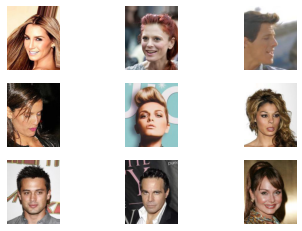

In [413]:
from PIL import Image
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(3,3,i+1)
    img = Image.open(imgs[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [419]:
torch.__version__

'1.8.1+cu102'

In [414]:
# 이미지는 항상 조심 : 사이즈가 다 다르다... 채널정보가 다를수도 있음
# 이미지 전처리 : 크기통일, 텐서, 정규화(각 채널별 평균은 0.5 , 표준편차는 0.2) , 채널정보 GrayScale 적용

In [432]:
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

# torch.set_float32_matmul_precision('medium')
# torch.backends.cuda.matmul.allow_tf32 = True

transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64), # 이미지 비율을 변형하지 않고 잘라냄
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageFolder(
    root = dir + "/img_align_celeba/",
    transform=transforms
)
loader = DataLoader(dataset, batch_size = 128, shuffle=True)

In [433]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 생성자를 구성하는 총 정의
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100,512,kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

In [434]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 감별자 구성 층 정의
        self.disc = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,1,kernel_size=4),
            nn.Sigmoid()
            
    )
    def forward(self, x):
        return self.disc(x)

In [435]:
# GAN의 학습을 원활하게 이루어지도록 가중치 초기화 설정
def weights_init(m):
    # 층의 종류 추출
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 합성곱 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 배치 정규화층 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [436]:
import tqdm
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [437]:
# 생성자 정의
G = Generator().to(device)
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
D.apply(weights_init)

G_optim = Adam(G.parameters(),lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(),lr=0.0001, betas=(0.5, 0.999))

In [438]:
import os
best_loss = float('inf')
for epochs in range(5):
    iterator = tqdm.tqdm(enumerate(loader,0),total=len(loader))
    
    for i, data in iterator:
        D_optim.zero_grad()
        # 실제 이미지 1, 생성 이미지 0으로 정답 설정
        label = torch.ones_like(data[1], dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)
        # 실제 이미지를 감별자에 입력
        real = D(data[0].to(device))
        # 실제 이미지에 대한 감별자의 오차 계산
        Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
        Dloss_real.backward()
        
        # 감별자 학습
        # 가짜 이미지 생성
        noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
        fake = G(noise)
        # 가짜 이미지를 감별자에 입력
        output = D(fake.detach())
        
        # 가짜 이미지에 대한 감별자의 오차 계산
        Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
        Dloss_fake.backward()
        
        # 감별자의 전체 오차를 학습
        Dloss = 0.5 * (Dloss_real + Dloss_fake)
        D_optim.step()
        
        # 생성자의 학습
        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output),label)
        Gloss.backward()
        
        G_optim.step()
        
        iterator.set_description(f'epoch:{epochs} iteration:{i} D_loss:{Dloss} Gloss:{Gloss}')
        
    if Gloss.item() < best_loss:
        best_loss = Gloss.item()
        torch.save(G.state_dict(), 'Generator.pth')
        torch.save(D.state_dict(), 'Discriminator.pth')
        print(f"Best model saved at epoch {epochs}, batch {i} with G loss: {Gloss.item()} and D loss: {Dloss.item()}")
        

epoch:0 iteration:1582 D_loss:0.08293721824884415 Gloss:6.571374893188477: 100%|██████████| 1583/1583 [06:58<00:00,  3.78it/s]    
  0%|          | 0/1583 [00:00<?, ?it/s]

Best model saved at epoch 0, batch 1582 with G loss: 6.571374893188477 and D loss: 0.08293721824884415


epoch:1 iteration:1582 D_loss:0.7351114749908447 Gloss:4.031375885009766: 100%|██████████| 1583/1583 [06:57<00:00,  3.79it/s]   
  0%|          | 0/1583 [00:00<?, ?it/s]

Best model saved at epoch 1, batch 1582 with G loss: 4.031375885009766 and D loss: 0.7351114749908447


epoch:2 iteration:1582 D_loss:0.06794789433479309 Gloss:4.542531967163086: 100%|██████████| 1583/1583 [06:56<00:00,  3.80it/s] 
epoch:3 iteration:1582 D_loss:1.665169358253479 Gloss:0.07167751342058182: 100%|██████████| 1583/1583 [06:57<00:00,  3.79it/s] 
  0%|          | 0/1583 [00:00<?, ?it/s]

Best model saved at epoch 3, batch 1582 with G loss: 0.07167751342058182 and D loss: 1.665169358253479


epoch:4 iteration:1582 D_loss:0.4199010133743286 Gloss:1.9149795770645142: 100%|██████████| 1583/1583 [06:57<00:00,  3.80it/s]  


In [439]:
print(type(G))  # Ensure this is torch.nn.Module
print(type(G_optim))  # Ensure this is torch.optim.Optimizer

<class '__main__.Generator'>
<class 'torch.optim.adam.Adam'>


In [448]:
torch.save(G.state_dict(), 'Generator2.pth')
torch.save(D.state_dict(), 'Discriminator2.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


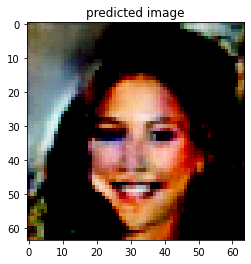

In [502]:
with torch.no_grad():
    G.load_state_dict(torch.load('Generator2.pth',map_location=device))
    # 랜덤한 하나의 점 지정
    feature_vector = torch.randn(1, 100, 1, 1).to(device)
    
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    plt.imshow(pred)
    plt.title('predicted image')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


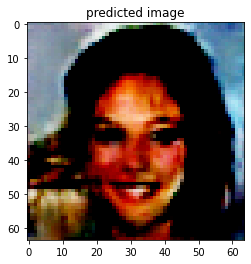

In [539]:
with torch.no_grad():
    G.load_state_dict(torch.load('Generator.pth',map_location=device))
    # 랜덤한 하나의 점 지정
    feature_vector = torch.randn(1, 100, 1, 1).to(device)
    
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()
    
    plt.imshow(pred)
    plt.title('predicted image')
    plt.show()

## SRGAN : 화질을 개선하는 GAN

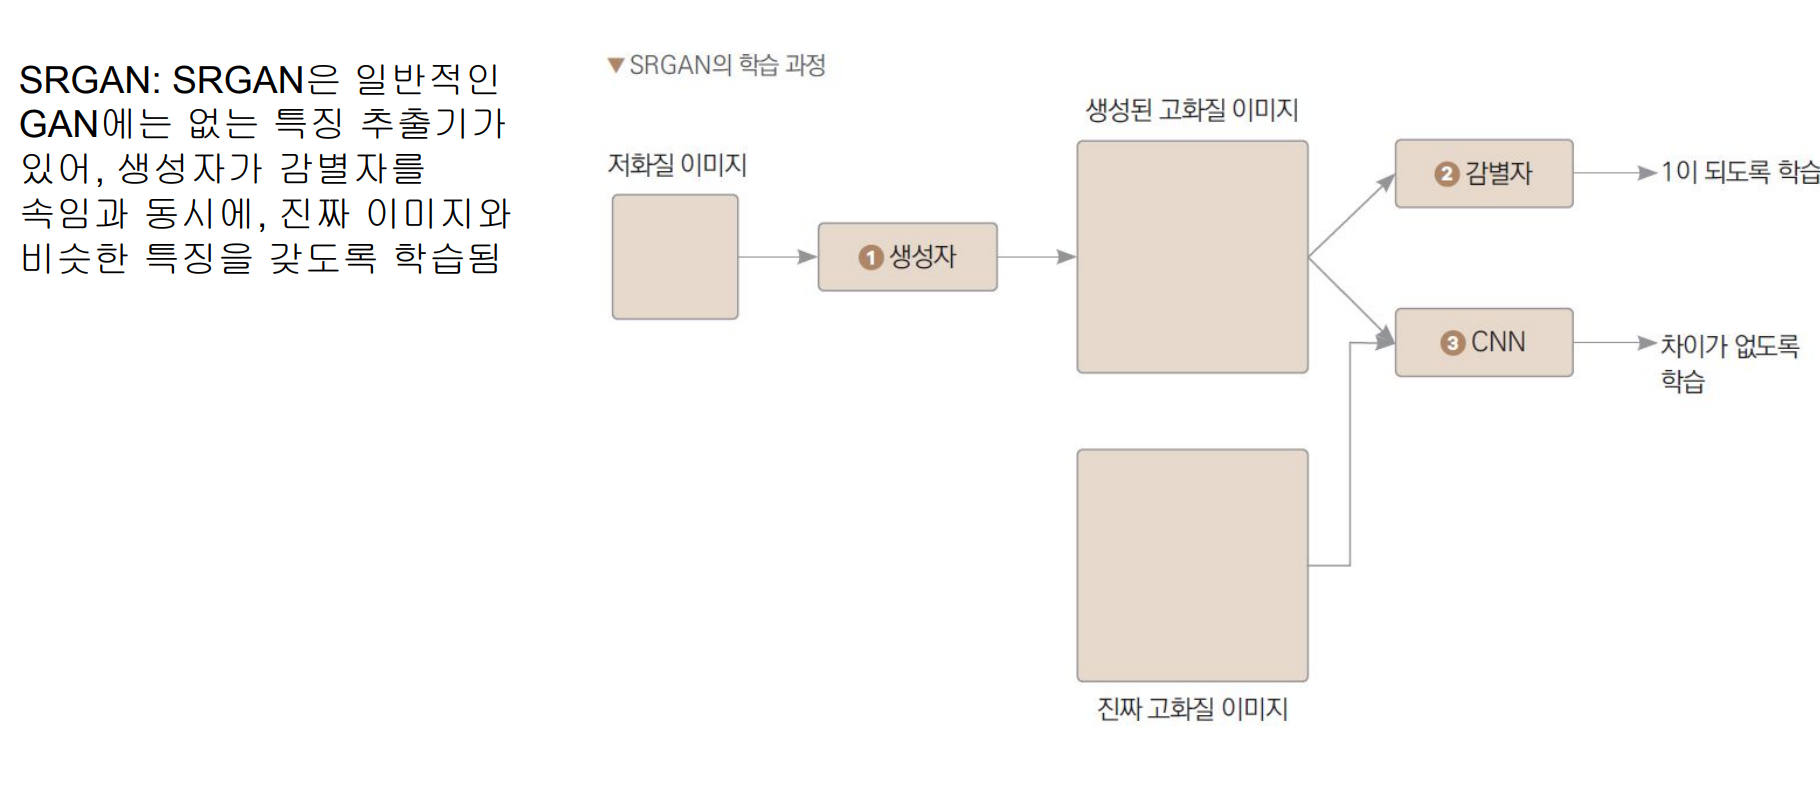

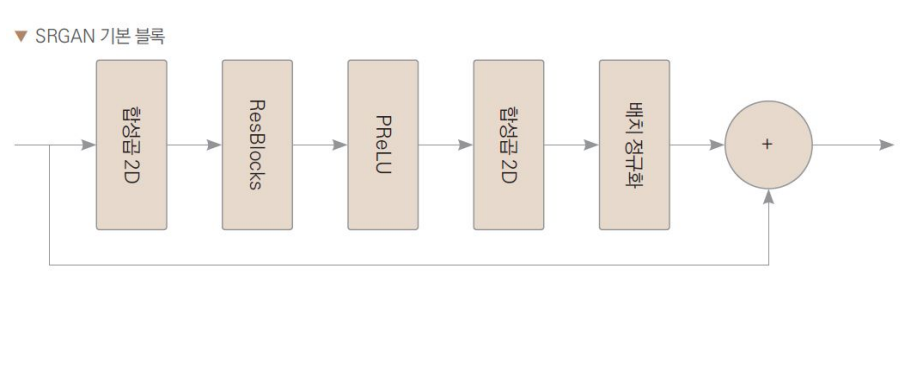

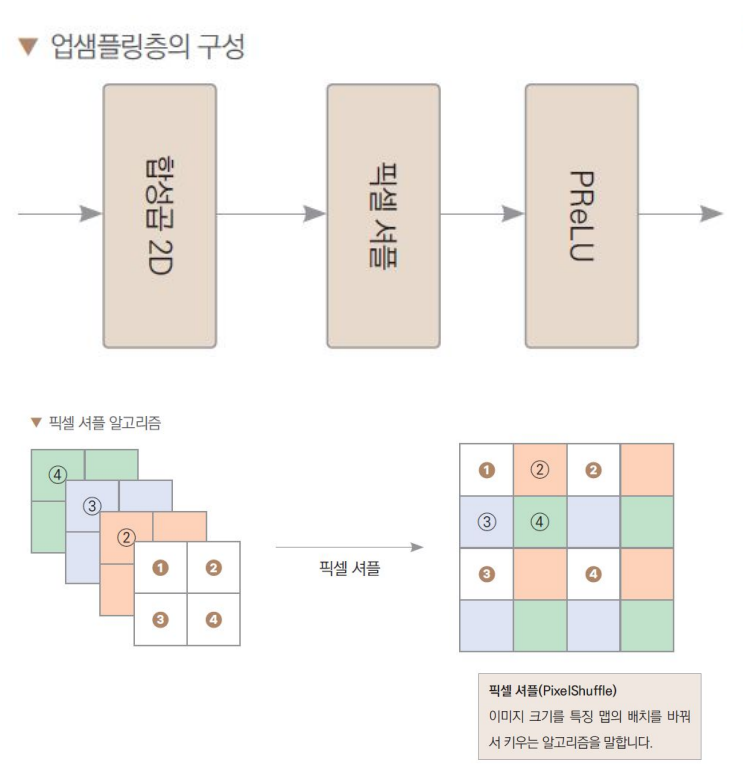

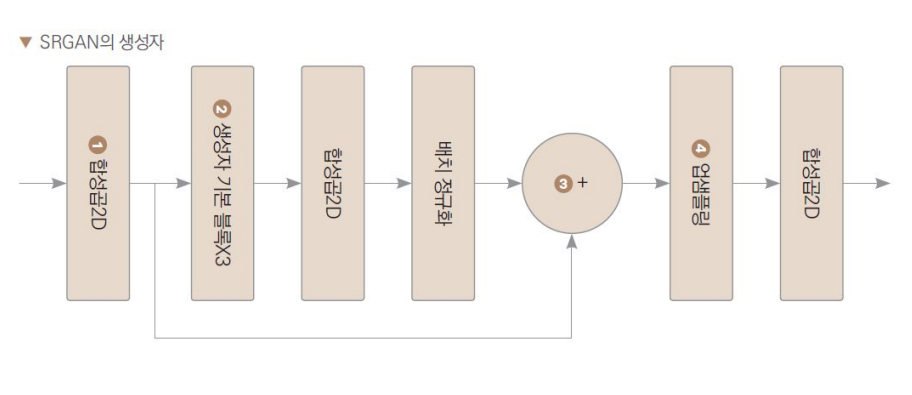

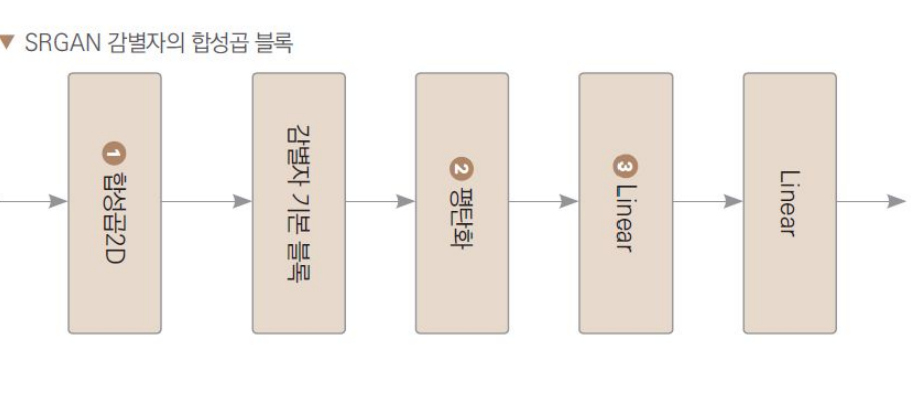

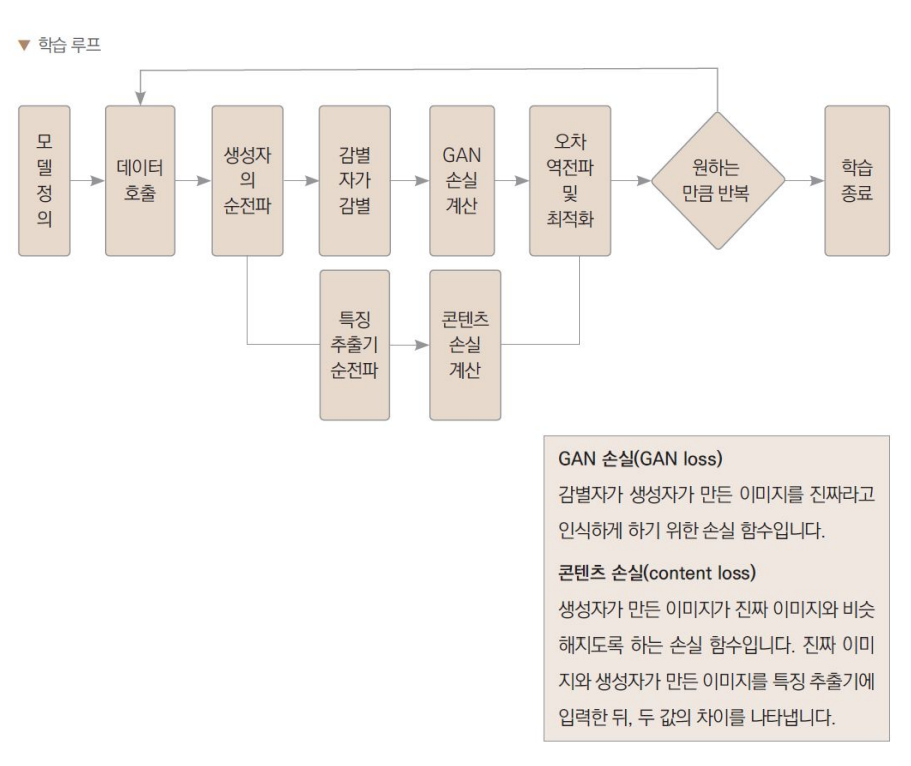

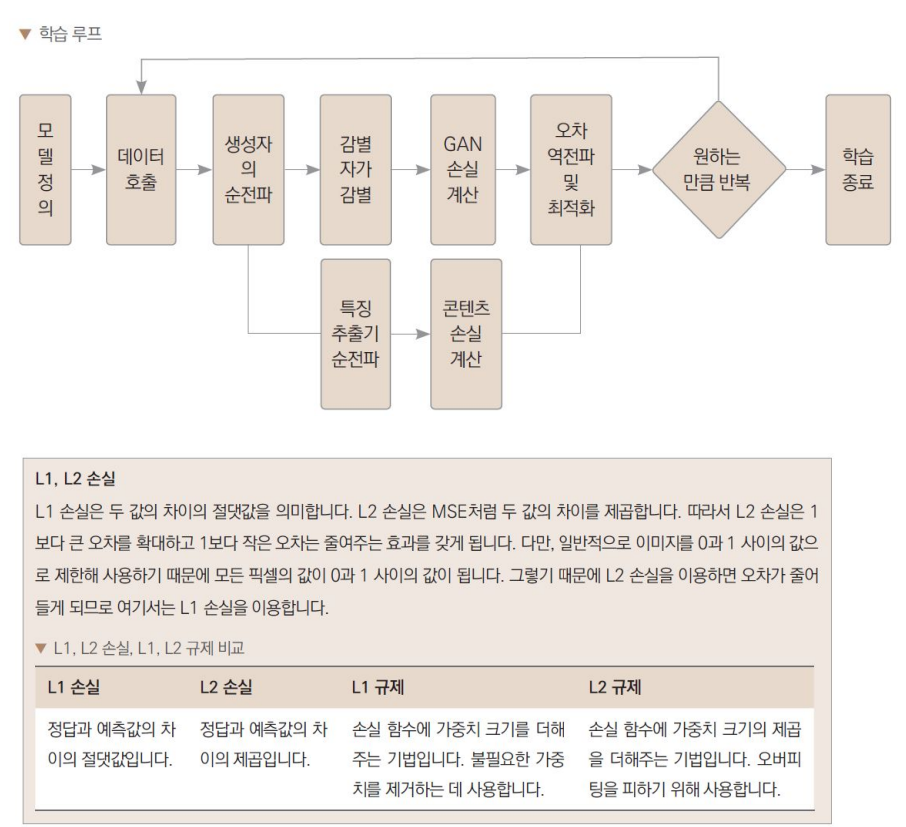

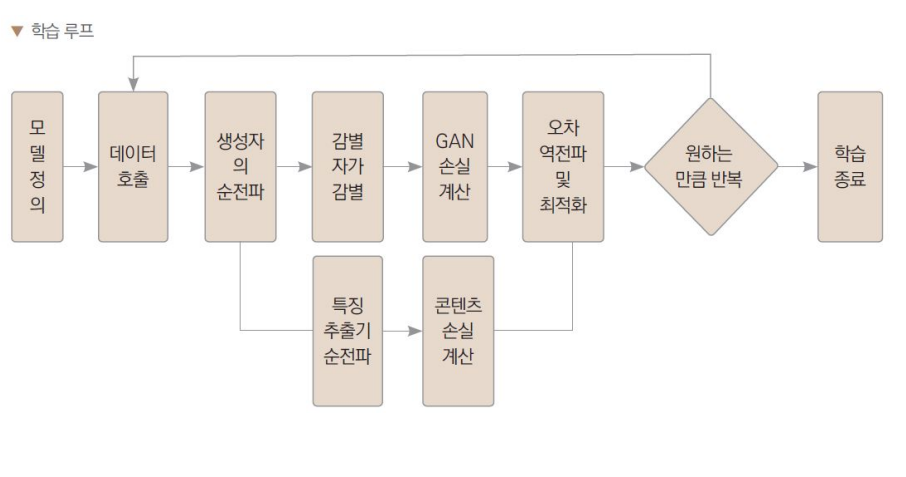

In [1]:
import glob
import torchvision.transforms as tf

from torch.utils.data.dataset import Dataset
from PIL import Image

class CelebA(Dataset):
    def __init__(self):
        self.imgs = sorted(glob(dir+'/**/*.jpg',recursive = True))
        
        mean_std = (0.5, 0.5, 0.5)
        
        # 입력용 이미지 생성
        self.low_res_tf = tf.Compose([
            tf.Resize((32,32)),
            tf.ToTensor(),
            tf.Normalize(mean_std, mean_std)
        ])
        
        # 정답용 이미지 생성
        self.high_res_tf = tf.Compose([
            tf.Resize((64,64)),
            tf.ToTensor(),
            tf.Normalize(mean_std, mean_std)
        ])
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = Image.open(self.imgs[i])
        
        img_low_res = self.low_res_tf(img)
        img_high_res = self.high_res_tf(img)
        
        return [img_low_res, img_high_res]

SyntaxError: invalid syntax (<ipython-input-1-1871bfb320b8>, line 5)

In [ ]:
import torch.nn as nn
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels, out+channels, kernel_size-3, stride-1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
    def forward(self, x):
        x_ = x
        x = self.layers(x)
        x = X_ + x
        return x

In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
from torchvision.models.vgg import vgg19

# 데이터셋
class CelebA(Dataset):
  def __init__(self, path):
    self.images = glob(f'{path}/img_align_celeba/img_align_celeba/*.jpg')
    self.low_res_tf =  tf.Compose([
        tf.Resize(32),
        tf.CenterCrop(32),
        tf.ToTensor(),
        tf.Normalize((0.5,0.5,0.5),(0.2,0.2,0.2))
    ])
    self.high_res_tf =  tf.Compose([
        tf.Resize(64),
        tf.CenterCrop(64),
        tf.ToTensor(),
        tf.Normalize((0.5,0.5,0.5),(0.2,0.2,0.2))
    ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # 저화질 이미지는 입력, 고화질 이미지는 정답
    img = Image.open(self.images[idx])
    low_res_img = self.low_res_tf(img)
    high_res_img = self.high_res_tf(img)
    return low_res_img, high_res_img


temp = CelebA(path)
temp2= next(iter(temp))
print('데이터셋 구조 :',temp2[0].shape, temp2[1].shape)

# SRGAN 기본 합성곱 블럭
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()
    # C-B-PR-C-B
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.PReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
    )
  def forward(self, x):
    x_ = x
    x = self.layers(x)
    x = x + x_  # 스킵커넥션인데.. 입려과 출력이 동일한 크기이므로 downsampling은 하지 않는다
    return x

# 업셈플링 층

# sample = torch.randn(1,16,8,8)  # B,C,H,W
# # upscale_factor만큼 가로와세로는 곱해지고.. 채널은 upscale_factor*2으로 나눈값이된다.
# nn.PixelShuffle(upscale_factor=2)(sample).shape   # [1, 4, 16, 16]
class UpSample(nn.Sequential):
  def __init__(self, in_channels, out_channels):
    super(UpSample, self).__init__(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.PixelShuffle(upscale_factor=2),
      nn.PReLU()
    )

# 생성자
# C - ResidualBlock*3 - C - B
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )
    self.residual = nn.Sequential(*[ResidualBlock(64,64) for _ in range(3)])
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.upsample_bolcks = nn.Sequential(
        UpSample(64,256)
    )
    self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)
  def forward(self, x):
    x = self.conv1(x)
    x_ = x  # 스킵커넥션을 위해서 첫번째 합성곱 출력을 저장
    x = self.residual(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = x + x_  # 스킵커넥션
    x = self.upsample_bolcks(x)  # 출력이 256이지만 PixelShuffle의 upscale_factor가 2이므로 2**2 즉 4로 256을 나누면 64
    x = self.conv3(x)
    return x

sample = torch.randn(1,3,32,32)
print('생성자의 결과 모댱 :', Generator()(sample).shape)
# 감별자 기본블럭
class DiscBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DiscBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
  def forward(self, x):
    return self.layers(x)
# 감별자
# C-DiscBlock-Flatt-fc-fc
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU()
    )
    self.disc_blocks =  DiscBlock(64,64)     # 64*32*32
    self.fc1 = nn.Linear(65536, 1024)
    self.fc2 = nn.Linear(1024, 1)
    self.activation = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):  # B, 3, 64,64
    x = self.conv1(x) # 64,64,64
    x = self.disc_blocks(x)    # 64 32 32
    x = torch.flatten(x,start_dim = 1)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

sample = torch.randn(1,3,64,64)
print('판별자 결과 모댱 :', Discriminator()(sample).shape)

# list(vgg19().features.children())[:9]
# 특성추출기(CNN) - 전이학습 vgg19
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    vgg19_model = vgg19(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9])
  def forward(self, x):
    return self.feature_extractor(x)
# 학습
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
# 데이터 로더
dataset = CelebA(path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)  # 배치에 속하지 않은 나머지 데이터들을 사용 안함 drop_last=True
# 생성자와 감별자 정의
G = Generator().to(device)
D = Discriminator().to(device)
# 특성추출기 정의
F = FeatureExtractor().to(device)
# 옵티마이져 정의
G_optim = Adam(G.parameters(), lr=1e-4)
D_optim = Adam(D.parameters(), lr=1e-4)

# 학습루프
for epoch in range(1):
  iterator = tqdm(dataloader)
  for low_res_img,hight_res_img in iterator:
    low_res_img = low_res_img.to(device)
    hight_res_img = hight_res_img.to(device)
    G_optim.zero_grad()
    D_optim.zero_grad()
    # 진짜이미지와 가짜이미지의 정답 라벨링
    label_true = torch.ones(8,1).to(device)
    label_fake = torch.zeros(8,1).to(device)
    # 생성자 학습
    fake_hight_img =  G(low_res_img)
    GAN_loss = nn.MSELoss()(D(fake_hight_img), label_true)
    # 생성자가 생성한 고화질이미의 특징 추출
    fake_feature = F(fake_hight_img)
    # 진짜 고화질 이미지의 특징 추출
    real_feature = F(hight_res_img)
    nn.L1Loss()(fake_feature, real_feature)

# 평가